Importing the neccessary libraries and dataset. Also printing first 5 rows to check if dataset is good.

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataset = pd.read_excel("HousePricePrediction.xlsx")

#Printing the first 5 records of the dataset
print(dataset.head(5))

   Id  MSSubClass MSZoning  LotArea LotConfig BldgType  OverallCond  \
0   0          60       RM     2200    Inside     1Fam            7   
1   1          60       RL     8450    Inside     1Fam            5   
2   2          20       RL     9600       FR2     1Fam            8   
3   3          60       RL    11250    Inside     1Fam            5   
4   4          70       RL     9550    Corner     1Fam            5   

   YearBuilt  YearRemodAdd Exterior1st  BsmtFinSF2  TotalBsmtSF  SalePrice  
0       2001          2001     VinylSd         0.0       1000.0        NaN  
1       2003          2003     VinylSd         0.0        856.0   208500.0  
2       1976          1976     MetalSd         0.0       1262.0   181500.0  
3       2001          2002     VinylSd         0.0        920.0   223500.0  
4       1915          1970     Wd Sdng         0.0        756.0   140000.0  


Checking the amount of data to make sure all was imported well.

In [97]:
dataset.shape

(2920, 13)

Listing each type of variable for data cleaning.

In [98]:
obj = (dataset.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:",len(object_cols))

int_ = (dataset.dtypes == 'int')
num_cols = list(int_[int_].index)
print("Integer variables:",len(num_cols))

fl = (dataset.dtypes == 'float')
fl_cols = list(fl[fl].index)
print("Float variables:",len(fl_cols))

Categorical variables: 4
Integer variables: 6
Float variables: 3


Plot to check the number of unique variables in each category.

<Axes: title={'center': 'No. Unique values of Categorical Features'}>

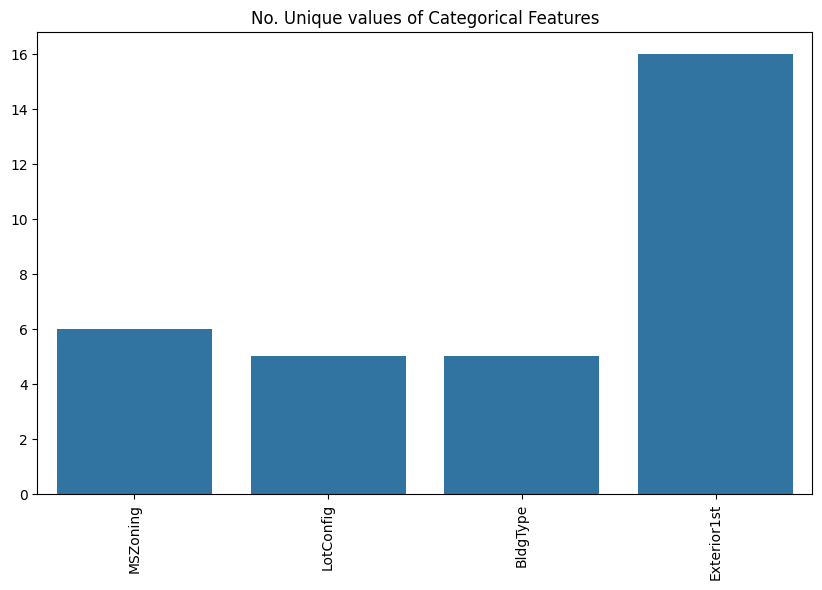

In [99]:
unique_values = []
for col in object_cols:
  unique_values.append(dataset[col].unique().size)
plt.figure(figsize=(10,6))
plt.title('No. Unique values of Categorical Features')
plt.xticks(rotation=90)
sns.barplot(x=object_cols,y=unique_values)

Plot for each of the unique values in each category

<ipython-input-100-7600a24242d8>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(11,4,index)


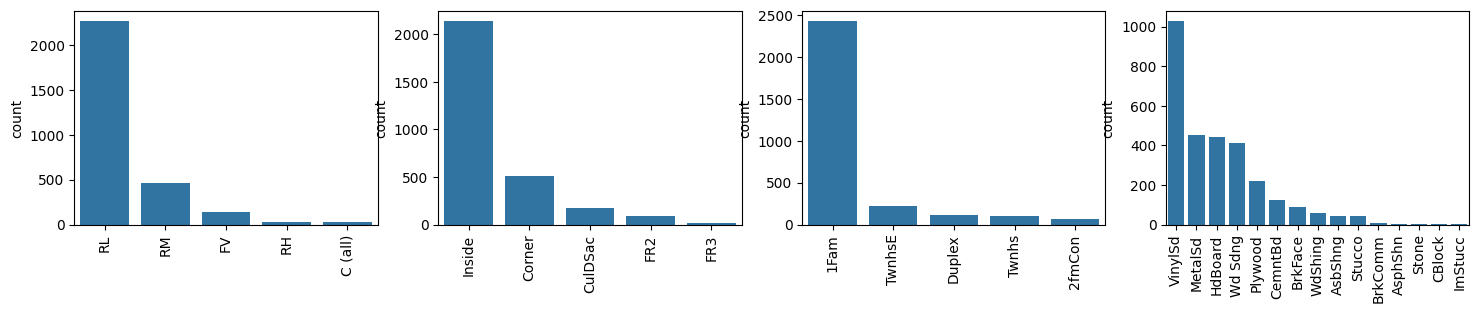

In [100]:
plt.figure(figsize=(18,36))
plt.title('Categorical Features: Distribution')
plt.xticks(rotation=90)
index = 1

for col in object_cols:
  y = dataset[col].value_counts()
  plt.subplot(11,4,index)
  plt.xticks(rotation=90)
  sns.barplot(x=list(y.index), y=y)
  index += 1

Data Cleaning including:
*   Dropping ID since it won't be used for training/validation
*   Making sure sale price is as float
*   Filling empty data with the mean value
*   Dropping any null values







In [101]:
dataset.drop(['Id'],
             axis=1,
             inplace=True)

In [102]:
dataset['SalePrice'] = dataset['SalePrice'].astype(float)

In [103]:
dataset['SalePrice'] = dataset['SalePrice'].fillna(dataset['SalePrice'].mean())

In [104]:
new_dataset = dataset.dropna()

Checking the amount of data left after cleaning

In [105]:
new_dataset.count()

MSSubClass      2914
MSZoning        2914
LotArea         2914
LotConfig       2914
BldgType        2914
OverallCond     2914
YearBuilt       2914
YearRemodAdd    2914
Exterior1st     2914
BsmtFinSF2      2914
TotalBsmtSF     2914
SalePrice       2914
dtype: int64

Making sure nothing is null in the data.

In [106]:
new_dataset.isnull().sum()

MSSubClass      0
MSZoning        0
LotArea         0
LotConfig       0
BldgType        0
OverallCond     0
YearBuilt       0
YearRemodAdd    0
Exterior1st     0
BsmtFinSF2      0
TotalBsmtSF     0
SalePrice       0
dtype: int64

Encoding the object data to turn it into numbers for better training/validation.

In [107]:
from sklearn.preprocessing import OneHotEncoder

s = (new_dataset.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)
print('No. of categorical features: ',
      len(object_cols))

Categorical variables:
['MSZoning', 'LotConfig', 'BldgType', 'Exterior1st']
No. of categorical features:  4


In [108]:
OH_encoder = OneHotEncoder(sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(new_dataset[object_cols]))
OH_cols.index = new_dataset.index
OH_cols.columns = OH_encoder.get_feature_names_out()
df_final = new_dataset.drop(object_cols, axis=1)
df_final = pd.concat([df_final, OH_cols], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Splitting data into training and validation data.

In [110]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

X = df_final.drop(['SalePrice'], axis=1)
Y = df_final['SalePrice']

# Split the training set into
# training and validation set
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X, Y, train_size=0.8, test_size=0.2, random_state=42, shuffle=False)

display(Y_valid)

2336    180921.19589
2337    180921.19589
2338    180921.19589
2339    180921.19589
2340    180921.19589
            ...     
2915    180921.19589
2916    180921.19589
2917    180921.19589
2918    180921.19589
2919    180921.19589
Name: SalePrice, Length: 583, dtype: float64

Training the linear regression model and using mean percentage error to check accuracy.

In [111]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

model_LR = LinearRegression()
model_LR.fit(X_train, Y_train)
Y_pred = model_LR.predict(X_valid)

print(mean_absolute_percentage_error(Y_valid, Y_pred))

0.1739536388053298


Concating the data to display datafram

In [112]:
predicted_df = pd.concat([Y_valid, pd.DataFrame(Y_pred, columns=['Predicted_Price'])], axis=1)

Changing to excel if needed to take a closer look into the data.

In [ ]:
predicted_df.to_excel('predicted_prices_regression.xlsx', index=False)

Displaying the final dataframe.

In [114]:
display(predicted_df)

,SalePrice,Predicted_Price
2336,180921.19589,NaN
2337,180921.19589,NaN
2338,180921.19589,NaN
2339,180921.19589,NaN
2340,180921.19589,NaN
...,...,...
578,NaN,144651.264096
579,NaN,143076.795064
580,NaN,190918.715269
581,NaN,204460.253927
